## Import Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import re
import nltk
nltk.download('words')
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
import wordcloud
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.manifold import TSNE
import sklearn
from gensim import corpora
from gensim.models import LsiModel

[nltk_data] Downloading package words to
[nltk_data]     C:\Users\Yufeng\AppData\Roaming\nltk_data...
[nltk_data]   Package words is already up-to-date!
unable to import 'smart_open.gcs', disabling that module


## 0. Research Objective

- __Research Objective__
    - There are a large amount of literatures in the database, but there are not any topics of them. Therefore, researchers, governments and universities can not have a quick review of what aspects of the research about COVID-19 is in shortage.
    - Thus, the __research objective__ of this report is to analyze the topic distribution of COVID-19 literatures compared with other literature by topic modeling.
    - The outcome of this report is to give advice that, compared to research of other virus (SARS or influenza), which aspects of the research on COVID-19 should pay more attention in the future.

## 1. Data Cleaning

- Apart from data cleaning, this section also contains the detection of COVID-19 literature. A simple way to estimate this is designed in section _1.2_ .
- Then the abstracts are tokenized and removed stopwords.

In [248]:
# data import
os.chdir('D:\MIE1624\Final_Project')
df=pd.read_csv('metadata.csv', usecols=['title','abstract','authors','doi','publish_time'])
print (df.shape)

#drop duplicates
df = df.drop_duplicates(subset='abstract', keep="first")

#drop NANs 
df=df.dropna()

# convert abstracts to lowercase
df["abstract"] = df["abstract"].str.lower()

#show 10 lines of the new dataframe
print (df.shape)
df.head(10)

(45774, 5)
(34809, 5)


,title,doi,abstract,publish_time,authors
0,SIANN: Strain Identification by Alignment to N...,10.1101/001727,next-generation sequencing is increasingly bei...,2014-01-10,Samuel Minot; Stephen D Turner; Krista L Ternu...
1,Spatial epidemiology of networked metapopulati...,10.1101/003889,an emerging disease is one infectious epidemic...,2014-06-04,Lin WANG; Xiang Li
2,Sequencing of the human IG light chain loci fr...,10.1101/006866,germline variation at immunoglobulin gene (ig)...,2014-07-03,Corey T Watson; Karyn Meltz Steinberg; Tina A ...
3,Bayesian mixture analysis for metagenomic comm...,10.1101/007476,deep sequencing of clinical samples is now an ...,2014-07-25,Sofia Morfopoulou; Vincent Plagnol
4,Mapping a viral phylogeny onto outbreak trees ...,10.1101/010389,developing methods to reconstruct transmission...,2014-11-11,Stephen P Velsko; Jonathan E Allen
5,The infant airway microbiome in health and dis...,10.1101/012070,the nasopharynx (np) is a reservoir for microb...,2014-12-02,Shu Mei Teo; Danny Mok; Kym Pham; Merci Kusel;...
6,Using heterogeneity in the population structur...,10.1101/017178,"abstractin 2013, u.s. swine producers were con...",2015-03-27,Eamon B. O’Dea; Harry Snelson; Shweta Bansal
7,"Big city, small world: Density, contact rates,...",10.1101/018481,macroscopic descriptions of populations common...,2015-04-27,Moritz U. G. Kraemer; T. Alex Perkins; Derek A...
8,MERS-CoV recombination: implications about the...,10.1101/020834,recombination is a process that unlinks neighb...,2015-06-12,Gytis Dudas; Andrew Rambaut
9,On the causes of evolutionary transition:trans...,10.1101/027722,a pattern in which nucleotide transitions are ...,2015-09-28,Arlin Stoltzfus; Ryan W. Norris


### 1.1 Clean the data

In [249]:
# convert the abstracts to lower case, and remove punctuations
def clean_data(row):
    row = row.lower()
    row = re.sub(r'[^a-zA-z0-9\s]', ' ', row) # substitute characters that are not letters or numbers
    return row

In [250]:
df['abstract'] = df['abstract'].apply(clean_data)

### 1.2 Detect literatures that focuse on COVID-19

- A simple way to roughly estimate which paper is focused on COVID-19 is to consider its publish time and keywords. Paper published after Nov. 2019 and contains keywords like covid19, novel coronavirus, wuhan, etc. are more likely to focus on COVID-19.

In [251]:
# convert publish time to datetime for filtering
df['publish_time'] = pd.to_datetime(df['publish_time'])

In [252]:
# select publish time later than Oct. 2019, the time the virus started to spread.
df_cov19 = df[df['publish_time'] > '2019-11-01']

In [253]:
# define keywords list
keywords = ['covid19', 'novel coronavirus', 'coronavirus', 'wuhan', 'hubei', 'ncov']
def kword_filter(row, keywords):
    if any([word for word in keywords if word in row] ):
        return row
    else:
        return 'NO'

In [254]:
df_cov19['abstract'] = df['abstract'].apply(kword_filter, args=(keywords,))

E:\Anaconda\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [255]:
df_cov19 = df_cov19[df_cov19['abstract'] != 'NO']

In [256]:
print('The number of paper focused on COVID-19 is %d' % df_cov19.shape[0])

The number of paper focused on COVID-19 is 1586


### 1.3 Tokenization and removing stop words

In [257]:
# build a dataframe that only contains abstracts
df_abs = df.drop(columns=['title', 'doi', 'publish_time', 'authors'])

- I also notice some of the abstracts begin with strings like 'abstractbackgroundthe' or 'abstractin'. It seems the word 'Abstract' and 'Background' at the beginning of the text has combined with the first word. So I also remove the 'abstract' or 'background' strings from the combinations in the tokenization funtion.

In [258]:
# define a funtion that tokenize the abstract
def token_abs (row):
   
    row = re.sub(r'abstract','', row)
    row = re.sub(r'background', '', row)
    
    tokenizer = RegexpTokenizer(r'\w+')
    row = tokenizer.tokenize(row) 
    
    return row

In [259]:
df_abs['abstract_token'] = df_abs['abstract'].apply(token_abs)

In [260]:
# define a funtion that remove stop words from tokenized abstracts
stopword_list = stopwords.words('english')
def remove_stpw(row, stopword_list):
    
    row = [word for word in row if word not in stopword_list]
    
    return row

In [261]:
df_abs['abstract_cleaned'] = df_abs['abstract_token'].apply(remove_stpw, args=(stopword_list,))

## 2. Exploratory Data Analysis

- To prepare for the __topic modeling__, the EDA part will be focused on 3 parts.
    - Compare the word counts of original text with text after tokenization and cleaned.
    - Visualize the word cloud of all database and literature only focused on COVID-19, to check whether there are differences.
    - Choose vectorization methods by comparing the results of t-SNE of Word Frequency and TF-IDF.

### 2.1 Comparison of word counts before and after removing stop words

In [262]:
# the word count for each column
def word_count(row):
    row = len(row)
    return row

In [263]:
df_abs['word_count_original'] = df_abs['abstract_token'].apply(word_count)
df_abs['word_count_cleaned'] = df_abs['abstract_cleaned'].apply(word_count)

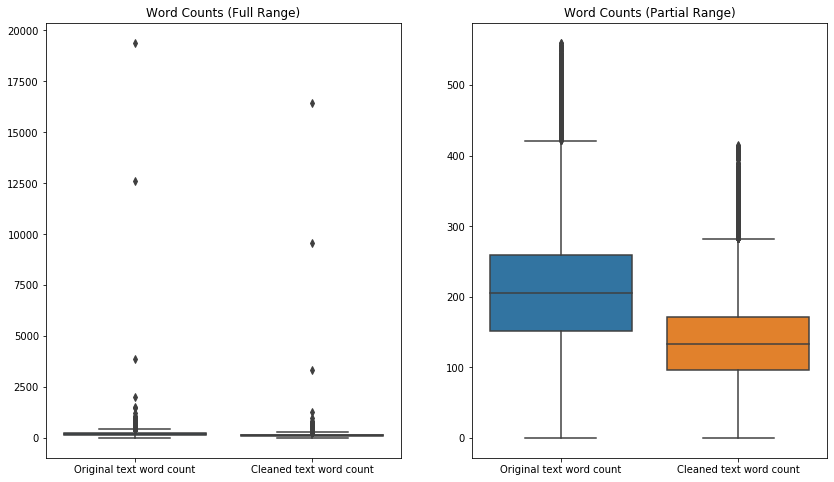

In [264]:
# visualize the results

fig, ax = plt.subplots(1,2,figsize=(14,8))

# sort the word count from low to high
origin = df_abs['word_count_original'].values.copy()
cleaned = df_abs['word_count_cleaned'].values.copy()
origin.sort()
cleaned.sort()
data_for_boxplot = pd.DataFrame({'Original text word count': origin, 'Cleaned text word count': cleaned})

sns.boxplot(data=data_for_boxplot, ax=ax[0])
ax[0].set_title('Word Counts (Full Range)')

sns.boxplot(data=data_for_boxplot[:-100], ax=ax[1])
ax[1].set_title('Word Counts (Partial Range)')

plt.show()

- __Analysis__
    - It can be seen from the left figure that the range of word count is quite large, from 0 to about 20000 words. Thus, the box plot is not easy to analyze with full range.
    - Therefore, after remving the largest 100 word counts, the right figure is clearer. Although the range of word count is large, most of the abstracts has no more than 400 words in originally with 200 words as average. After data cleaning, most abstracts remains 300 words with 150 words average.
    - Thus, even stopwords have been removed, the remained text still keeps the most of the original contents. The database still has abundant contents for further text mining.

### 2.2 Word cloud of all literature and literature focused on COVID-19

In [265]:
df_cov19 = df_abs.loc[df_cov19.index]

In [266]:
def corpus_for_wordcloud(data):
    corpus = []
    for abstract in data['abstract_cleaned']:
        corpus += abstract
    
    corpus = ' '.join(corpus)
    
    return corpus

In [267]:
text_all = corpus_for_wordcloud(df_abs)
text_cov19 = corpus_for_wordcloud(df_cov19)

In [268]:
from wordcloud import WordCloud

In [269]:
wordcloud_all = WordCloud(width = 800, height = 800, background_color ='white', min_font_size = 10).generate(text=text_all)
wordcloud_cov19 = WordCloud(width = 800, height = 800, background_color ='white', min_font_size = 10).generate(text=text_cov19)

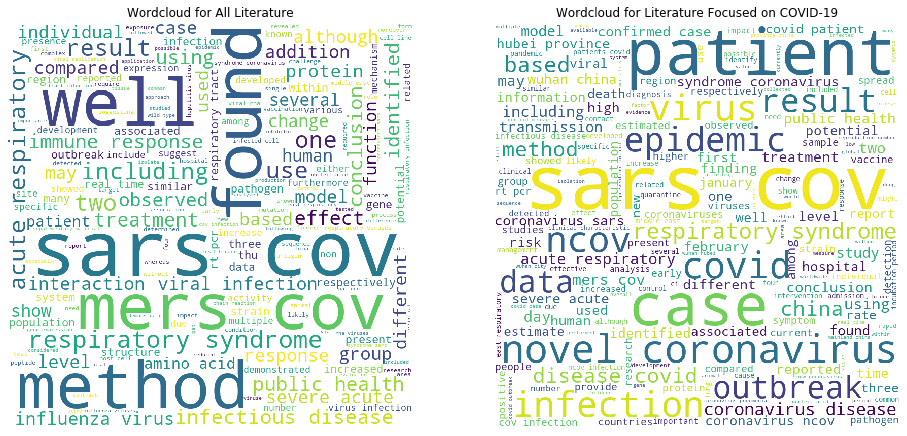

In [270]:
fig, ax = plt.subplots(1,2, figsize=(16,8))

ax[0].imshow(wordcloud_all)
ax[1].imshow(wordcloud_cov19)
ax[0].axis('off')
ax[1].axis('off')
ax[0].set_title('Wordcloud for All Literature')
ax[1].set_title('Wordcloud for Literature Focused on COVID-19')

plt.show()

- __Analysis__
    - Overall, the two word cloud are similar. The words 'sars', 'cov', 'respiratory', etc. are both frequent in two data.
    - But there are also obvious differences. There are obvious key words in COVID-19 dataset, like 'novel', 'wuhan' indicating the name of the virus and the place the virus firstly outbreak. More importantly, compared to the overall dataset, the key words like 'outbreak', 'death' and 'confirmed case' are more frequent in COVID-19 dataset. These are all the well-known tags of the virus so far.
    - The differences in the word frequency also indicate the topic distribution of COVID-19 papers are possibly different from the overall dataset.

### 2.3 Check topic modeling potentials by t-SNE

- During the feature extraction process, various methods can be chosen for data vectorization. And the vectorization methods play an important role in the performance of unsupervised learning. Thus, it is worthwhile to selecting a suitable way of vectorization.
- The selection method will be the visulization in this section. Two vectorization methods (Word Frequency and TF-IDF) will be tried here. t-SNE will be used for dimensionality reduction to visualize the distribution of data under different methods of vecterization.

- The t-SNE is too compuational to consider all the samples, thus, 50% of the samples are randomly selected.
- For the same reason, only the top 256 frequent words from word bag are selected
- The effect of this simplification:
    - It won't influence the whole text mining process, because all the samples will still be used during the training process. 
    - To be more precise I have tried some different fraction of sample size. The figures visualized similar after the sample size larger than 50%.
- Selection of hyperparameter, _perflexity_ : I also tried and compared different values, and found 30 (default value) is the best.

In [271]:
# funtion for building corpus for vecterization
def build_corpus(data):
    corpus = []
    for text in data['abstract_cleaned']:
        text_comb = ' '.join(text)
        corpus.append(text_comb)
        
    return corpus

In [272]:
# randomly select 50% samples
df_abs_rand = df_abs.sample(frac=0.5)

In [273]:
# build corpus for veterization
corpus_all = build_corpus(df_abs_rand)

In [274]:
# TF-IDF vectorization
tf_vectorizer = TfidfVectorizer(use_idf=True, smooth_idf=True, norm=None, max_features=2**8)
X_tf = tf_vectorizer.fit_transform(corpus_all).toarray()

In [275]:
# word count vectorization
wf_vectorizer = CountVectorizer(max_features=2**8)
X_wf = wf_vectorizer.fit_transform(corpus_all).toarray()

In [276]:
# t-SNE for TF-IDF
t_sne = TSNE(verbose=True)
X_tf_embedded = t_sne.fit_transform(X_tf)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 17404 samples in 2.232s...
[t-SNE] Computed neighbors for 17404 samples in 111.831s...
[t-SNE] Computed conditional probabilities for sample 1000 / 17404
[t-SNE] Computed conditional probabilities for sample 2000 / 17404
[t-SNE] Computed conditional probabilities for sample 3000 / 17404
[t-SNE] Computed conditional probabilities for sample 4000 / 17404
[t-SNE] Computed conditional probabilities for sample 5000 / 17404
[t-SNE] Computed conditional probabilities for sample 6000 / 17404
[t-SNE] Computed conditional probabilities for sample 7000 / 17404
[t-SNE] Computed conditional probabilities for sample 8000 / 17404
[t-SNE] Computed conditional probabilities for sample 9000 / 17404
[t-SNE] Computed conditional probabilities for sample 10000 / 17404
[t-SNE] Computed conditional probabilities for sample 11000 / 17404
[t-SNE] Computed conditional probabilities for sample 12000 / 17404
[t-SNE] Computed conditional probabilities for s

In [278]:
# t-SNE for Word Frquency
X_wf_embedded = t_sne.fit_transform(X_wf)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 17404 samples in 2.283s...
[t-SNE] Computed neighbors for 17404 samples in 116.820s...
[t-SNE] Computed conditional probabilities for sample 1000 / 17404
[t-SNE] Computed conditional probabilities for sample 2000 / 17404
[t-SNE] Computed conditional probabilities for sample 3000 / 17404
[t-SNE] Computed conditional probabilities for sample 4000 / 17404
[t-SNE] Computed conditional probabilities for sample 5000 / 17404
[t-SNE] Computed conditional probabilities for sample 6000 / 17404
[t-SNE] Computed conditional probabilities for sample 7000 / 17404
[t-SNE] Computed conditional probabilities for sample 8000 / 17404
[t-SNE] Computed conditional probabilities for sample 9000 / 17404
[t-SNE] Computed conditional probabilities for sample 10000 / 17404
[t-SNE] Computed conditional probabilities for sample 11000 / 17404
[t-SNE] Computed conditional probabilities for sample 12000 / 17404
[t-SNE] Computed conditional probabilities for s

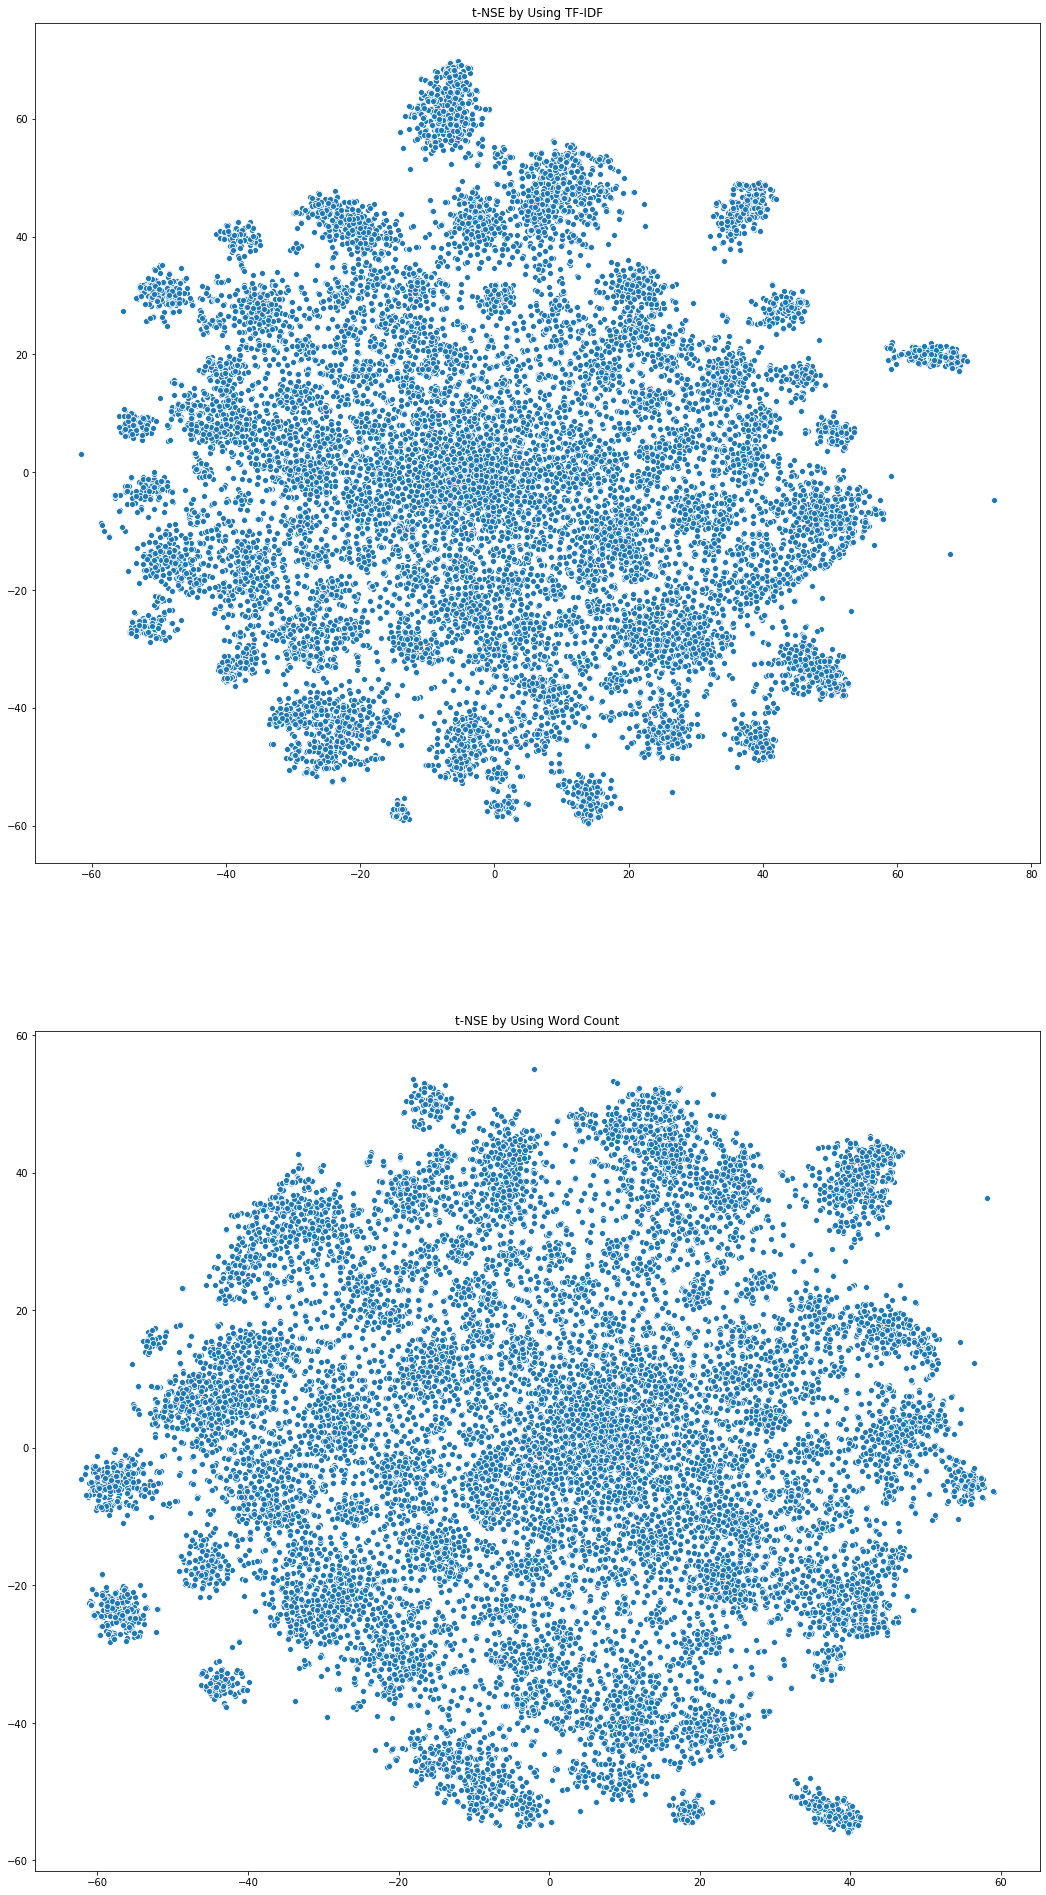

In [279]:
# visualize the results
fig, ax = plt.subplots(2,1, figsize=(18,34))
sns.scatterplot(X_tf_embedded[:,0], X_tf_embedded[:,1], palette='bright', ax=ax[0])
sns.scatterplot(X_wf_embedded[:,0], X_wf_embedded[:,1], palette='bright', ax=ax[1])

ax[0].set_title('t-NSE by Using TF-IDF')
ax[1].set_title('t-NSE by Using Word Count')
plt.show()

- Analysis
    - Overall, the two figures are quite similar meaning there are not huge differences when using any of the as features. The overall trend for both figures is small clusters appears at the surroundings and the center appear to be a whole cluster.
    - The Word Frequency feature is more distributed and clustered, thus, it can better distinguish different type of paper. Therefore, Word Frequecny has better potential for topic modeling.
    - The following part only considers Word Frequency as features.

### 3. Model Selection and Training Process

- This report will use Latent Semantic Analysis (LSA) to model the topics of the literatures. 
- The _reason_ of using LSA is that it is the most commenly used topic modeling methods, also it is not computational and is suitable for the large dataset.
- The library will be used in gensim, the features will use Word Frequency.

In [280]:
def token_text(data):
    text_tokened = []
    for text in data['abstract_cleaned']:
        text_tokened.append(text)
        
    return text_tokened

In [281]:
# build dictionary for LSA
text_for_dict = token_text(df_abs)
dictionary = corpora.Dictionary(text_for_dict)
# build document-term matrix
doc_term_matrix = [dictionary.doc2bow(abstract) for abstract in text_for_dict]

### 3.1 Tuning hyperparameters

- The hyperparameter can be tunned in LSA is the number of topics.
- The performance measurement in each model is the Topic Coherence (TC). The higher the TC, the better the model.
- The parameter is tunned by grid search.
- Due to it is unsupervised learning, cross validation is not needed.

In [ ]:
# grid search for model tunning

coherence_score = []

for number in range(2,21):
    model = LsiModel(doc_term_matrix, num_topics=number, id2word=dictionary)
    
    tc_score = CoherenceModel(model=model, texts=text_for_dict,dictionary=dictionary, coherence='c_v').get_coherence()
    coherence_score.append(tc_score)
    print('Tried', number)

Tried 2


In [ ]:
# visualize the tunning results
plt.figure(figsize=(10,8))
sns.lineplot(x=range(2,21), y=coherence_score)
plt.title('The Coherence Score with Different Topic Numbers')

plt.show()

- In this run, the best number of topics is __4__ . Thus, there will be 4 topics in the database.

In [ ]:
# get the best model
model_opt = LsiModel(doc_term_matrix, num_topics=4, id2word=dictionary)

### 3.2 Classify each literature by topics

- The principle of LSA is PCA, thus the topics will be the linear combination of all the words in the bag of word.
- To determine the topic of one paper, the co-ordination of the paper will be calcualted. The topic corresponds with the largest cordination will be the topic of this paper. The disadvantage of the idea is that some co-ordinations of a paper may be similar, so this paper is likely to be a multi-topic literatures. But to simplify the question, only single topic will be considered in this report.

In [ ]:
topic_labels = []
for m in range(len(doc_term_matrix)):
    
    coordin = model_opt[doc_term_matrix[m]]
    if coordin != []:
        coordin_value = [tup[1] for tup in coordin]
        max_index = coordin_value.index(max(coordin_value))
        topic_label = coordin[max_index][0]
        topic_labels.append(topic_label)
    else:
        topic_labels.append('empty')

- Combine the topics with the database.

In [ ]:
df_abs['topics'] = topic_labels

In [ ]:
plt.figure(figsize=(10,7))
sns.countplot(df_abs['topics'])
plt.title('Topic Distribution for the Whole Dataset')

plt.show()

- Plot the topic distributions for the whole dataset.
    - The reason there is an 'emplty' label is there is an empty abstract, so it is labeled as 'empty' in the last step.
    - Overall, the figure shows that the distribution of the label is significantly imbalanced. The topic 1 is the dominant part. Topic 0 and 3 has less samples, and there are no papers belong to topic 2 at all.
    - The reason of the imbalanced labels might be the nature of LSA. Because the PCA process is tend to find a principle that represents the most of the data, so it is possible for one topic become the dominant topic.
    - To verify whether the unsupervised learning is reasonable, I also used _k-means_ to cluster the data.

## 3.3 Verify the results by mini-batch k-means

- The reason using the mini-batch k-means is that it is faster for large dataset.
- The k value is selected as 4, the same as the number derived by LSA.

In [ ]:
from sklearn.cluster import MiniBatchKMeans

k = 4
kmeans = MiniBatchKMeans(n_clusters=k, random_state=20)
y_pred = kmeans.fit_predict(X_wf)

In [ ]:
plt.figure(figsize=(10,6))
sns.countplot(y_pred)
plt.title('Topic Distribution by k-means')

plt.show()

- __Analysis__

    - First, it should be noted that the topic number in k-means model is not necessarily the same as it in LSA model.
    - The figure shows that the results from k-means clustering also give the similar trend as the results from LSA: One of the topic is the largest (topic 0), two topics have less topics (topic 1,3), and one topic has the minimum number of papers (topic 2).
    - The similar trend indicates that the result from LSA is reasonable.

## 4. Deriving Insights and Suggestion for Current Situation

### 4.1 Interpreting the topics

In [ ]:
model_opt.show_topics(num_words=50,formatted=False)

- The above cell prints the top 50 words in each topic.
- For topic 0, there are lots of words related to syndrome, such as 'allergic', 'asthma', 'atopic', 'rhinitis', etc. For topic 1, there are much words about virus, such as 'cov', 'influenza', 'sars', 'coronavirus'. For topic 3, words like 'cell', 'protein' are frequently appeared.
- Thus, we can infer that topic 0 is about sydrome or characteristics of disease, topic 1 is about disease like coronavirus or SARS and topic 3 is about cell or molecule-level research.
- To verify this hypothesis, some __representative titles__ of papers have been selected and listed below, together with the __summary of the feature of each topic__.

- __Topic 0:__ The macro characteristics of virus, the impact of other disease or respiratory syndrome on health
    - Chronic hM3Dq signaling in microglia ameliorates neuroinflammation in male mice
    - Clinical features and progression of acute respiratory distress syndrome in coronavirus disease 2019
- __Topic 1:__ The infection models, identification methods and vaccine, etc.
    - SIANN: Strain Identification by Alignment to Near Neighbors
    - Fractional Dosing of Yellow Fever Vaccine to Extend Supply: A Modeling Study
- __Topic 3:__ Focus on molecule and micro-level
    - Structure of the chromatin remodelling enzyme Chd1 bound to a ubiquitinylated nucleosome
    - The alkyl side chain of PACA nanoparticles dictates the impact on cellular stress responses and the mode of particle-induced cell death
    - The immunomodulatory CEA cell adhesion molecule 6 (CEACAM6/CD66c) is a candidate receptor for the influenza A virus

### 4.2 Insights and suggestions

- Compare topic distributions of whole dataset and COVID-19 dataset

In [ ]:
# labels for cov19 dataset
cov19_labels = df_abs.loc[df_cov19.index]['topics']

# compare two set of labels by visualization
fig, ax = plt.subplots(2,1, figsize=(10,13))

sns.countplot(df_abs['topics'], order=[0,1,2,3], ax=ax[0])
sns.countplot(cov19_labels, order=[0,1,2,3], ax=ax[1])

ax[0].set_title('Topic Distribution for the Whole Dataset')
ax[1].set_title('Topic Distribution for the COVID-19 Dataset')

plt.show()

- __Analysis__

    - The comparison of the two figures illustrates that the literatures related to COVID-19 has almost the same trend as the whole dataset on __topic 0__ and __topic 1__. But there are not any papers related to __topic 3__ for COVID-19. 
    - This finding is reasonable because topic 3 related to the micro-level research. The COVID-19 appears only in a short time with outbreaks all over the world. Thus, the earliest research must focus on the macro characteristics, infection models and vaccines, which are the mostly needed so far. But cell or molecule-level research will cost longer time to gain useful insights, thus there are any papers collected by the dataset.
    - Thus, the insight gain from the analysis is that although lots of papers about COVID-19 has been published, there aren't any knowledge focusing on micro-level has bee shared to research community.
    
- __Suggestions__
    - Industries and governments should realize that the most knowledge about the virus is only the macro-level. We may know less about the virus in detail. So fundings and supports should also focus on related topics.
    - Medical professonals (such as doctors and nurse) and populations should realize that without micro-level knowledge, vaccines can not be generated so fast, thus long-term measurements should be take to protection themselves.
    - For scientist, it is urgent to conduct research related to topic 3 to gain more insights about the virus.
    
- Finally, the insights gain from the analysis can justify why scientist are now focusing on DNA sequencing and related research. There are also some updates in recently indicating scientist do put more focus on micro-level research now. And based on the micro-level research, the pilot vaccine has been tested on human in both China and America. Thus, text mining can find insights from the massive database.